In [67]:
import math, os
import pydicom
import numpy as np
import pandas as pd
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

- crop edge out : some wrong value
- find MTF bar

In [68]:
# by col
def find_edge_col(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for c in range(ncols) :
        is_c = None
        for r in range(nrows) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(c)
                is_c = True
                appended = True # append number already
                none_count = 0
                break
        if not is_c :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    w_min, w_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if w_max-w_min < int(0.15*ncols) :
        w_crop = w_max-w_min+5# prevent it's equalt = 0
        w_min, w_max = find_edge_col(arr[:, w_crop:])
        w_min, w_max = w_min + w_crop, w_max + w_crop
    return w_min, w_max

In [69]:
# by row
def find_edge_row(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for r in range(nrows) :
        is_r = None
        for c in range(ncols) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(r)
                is_r = True
                appended = True # append number already
                none_count = 0
                break
        if not is_r :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    h_min, h_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if h_max-h_min < int(0.15*nrows) :
        h_crop = h_max-h_min+5 # prevent it's equalt = 0
        h_min, h_max, start_val = find_edge_row(arr[h_crop:, :])
        h_min, h_max = h_min + h_crop, h_max + h_crop
    return h_min, h_max, start_val

64 850
542 830


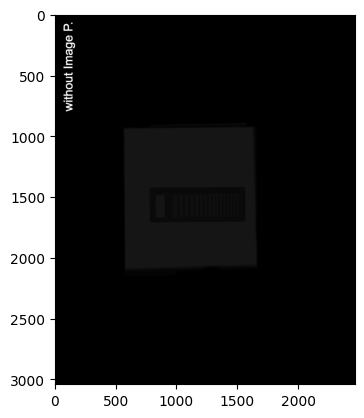

In [70]:
# dicom_data = pydicom.dcmread("y")
dicom_data = pydicom.dcmread("MTF_TEST\MTF_BAR (13)")
arr = dicom_data.pixel_array
# arr = ndimage.rotate(arr, 90)[:, 200: 1500] # TODO with this "y" file
arr = ndimage.rotate(arr, 90)
display(arr, True)
h, w = arr.shape
# assume crop if size > 2,000 (not crop yet)
p = 0.24
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]

ecrop = [int(0.05*h), int(0.95*h), int(0.05*w), int(0.95*w)]
arr = arr[ecrop[0]: ecrop[1], ecrop[2]: ecrop[3]]

h, w = arr.shape
# display(arr)
# find MTF bar
p = 0.33
p_mean = np.mean(arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))])
# display(arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))])
parr = np.where(arr>p_mean, 1, 0)
# display(parr, True)
# width finding
vc = [int(h*0.1), int(h/2)]
varr = parr[vc[0]: vc[1]]
w_min, w_max = find_edge_col(varr)
print(w_min, w_max)
# height finding
hc = [int(w*0.1), int(w/2)]
harr = parr[:, hc[0]: hc[1]]
h_min, h_max, start_val = find_edge_row(harr)
print(h_min, h_max)
# processing crop, inv, rotate to horizontal
need_inv = start_val == 1
l1, l2 = h_max-h_min, w_max-w_min
need_rotate = l1 > l2 
add_crop = int(0.1*l1) if l1>l2 else int(0.1*l2)
h_min, h_max = max(0, h_min-add_crop), h_max+add_crop # prevent negative 
w_min, w_max = max(0, w_min-add_crop), w_max+add_crop
arr = arr[h_min: h_max, w_min: w_max]
h, w = arr.shape
if need_rotate :
    arr = ndimage.rotate(arr, 90)
    h, w = arr.shape
    print("RO")

In [71]:
arr.shape, need_inv

((444, 928), True)

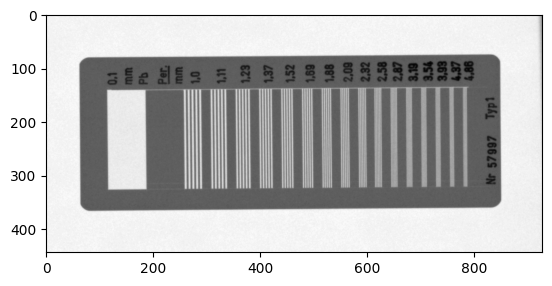

In [72]:
# arr = ndimage.rotate(arr, 180)
display(arr, True)

In [73]:
h, w

(444, 928)

In [74]:
hp = int(0.28*h)
wp = int(0.03*w)

### FOCUS

In [75]:
focus_l = arr[h-2*hp: int(h*.95), wp*9: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(225, 54)

In [76]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by col
    Return: argdiff in len(col)
    """
    nrows, ncols = arr.shape
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [77]:
arg_diffs = argdiffs(focus_l)
len(arg_diffs)

54

In [78]:
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
unique_elements, counts

(array([129, 168, 169]), array([ 4, 20, 30], dtype=int64))

In [79]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

169

In [80]:
focus_r = arr[h-2*hp: int(h*.95), w-(wp*11): w-(wp*9)]
nrows, ncols = focus_r.shape
nrows, ncols

(225, 54)

In [81]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

165

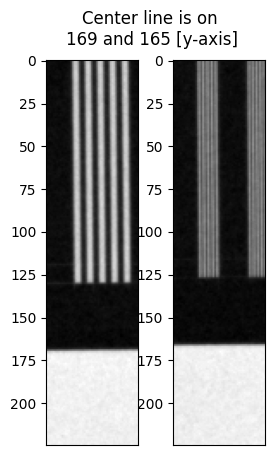

In [82]:
plt.figure(figsize=(3, 5))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [83]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    print(theta_r)
    theta_d = math.degrees(theta_r)
    return theta_d

In [84]:
y2, y1

(165, 169)

In [85]:
theta = find_theta(w, y1, y2)
theta

-0.004310318133814043


-0.24696303742624987

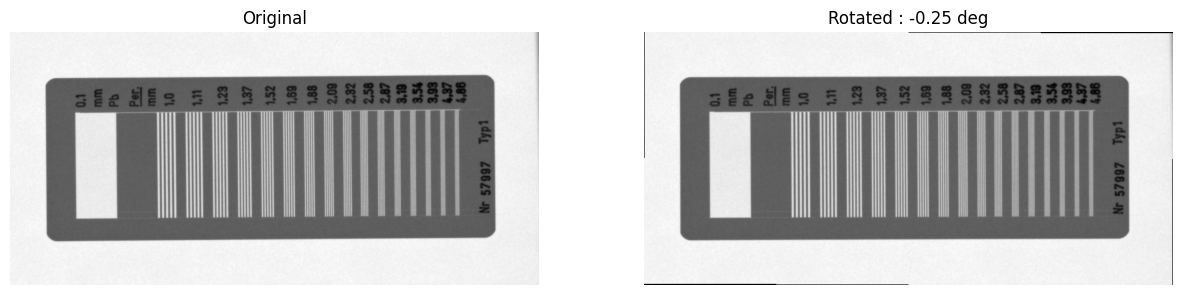

In [86]:
if theta > 3 :
    # wrong direction
    arr = ndimage.rotate(arr, 180)

rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [87]:
h, w = rotate_img.shape
h, w

(444, 928)

In [88]:
hp = int(0.11*h)
wp = int(0.10*w)

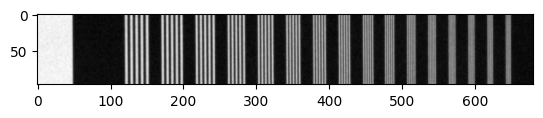

In [89]:
focus_crop = (h//2-hp, h//2+hp, int(wp*1.5), w-int(wp*1.2))
focus = rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]]
# focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
display(focus, True)

In [90]:
focus.shape

(96, 680)

11.317103029824121


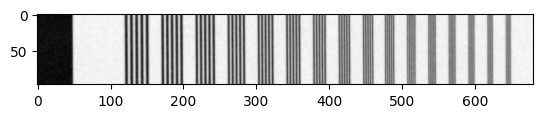

In [91]:
rotate_check = focus[:, :int(wp/3)]
std = np.std(rotate_check)
print(std)
if std > (focus.max() - focus.min())/30 :
    rotate_img = ndimage.rotate(rotate_img, 180)
    # focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
    focus = rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]]

if need_inv :
    # inv lUT
    max_pixel = focus.max()
    min_pixel = focus.min()
    # focus = max_pixel - focus + min_pixel 
    rotate_img = max_pixel - rotate_img + min_pixel
    focus = rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]]
    display(focus, True)

In [92]:
focus.shape

(96, 680)

444 928


(174, 270, 138, 818)

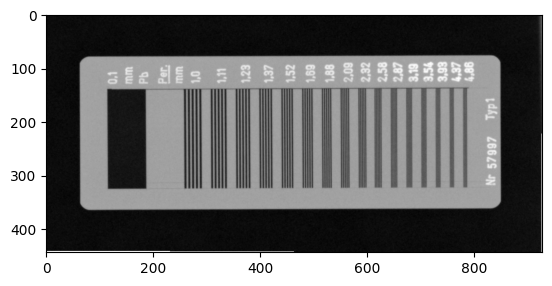

In [93]:
print(h, w)
display(rotate_img, True)
focus_crop

In [94]:
# mean by col
oneline_ori = np.mean(focus, axis=0, dtype=np.uint32)
p_mean = np.mean(oneline_ori)
oneline = np.where(oneline_ori > p_mean, 1, 0)
s = np.vstack((oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline))
display(s)

In [95]:
space_ts = int(0.02*len(oneline))
positions = []
is_start = True
start_val = None
none_count = 0 # for not lp
for idx, val in enumerate(oneline) :
    if idx+1 == len(oneline) and len(positions) != 17 : # forgot last one
            positions.append((start_val, idx-space_ts))
    # just first lp
    if len(positions) == 0 :
        if val == 1 :
            positions.append((0, idx))
    else :
        if is_start :
            if val == 0 :
                is_start = False
                start_val = idx
        else :
            if val == 1 :
                none_count += 1
                if none_count > space_ts :
                    positions.append((start_val, idx-space_ts)) # back to correct point
                    is_start = True
                    none_count = 0
            else :
                none_count = 0

In [96]:
positions, len(positions)

([(0, 50),
  (120, 153),
  (170, 200),
  (217, 244),
  (261, 286),
  (302, 325),
  (341, 361),
  (378, 396),
  (413, 430),
  (447, 461),
  (477, 490),
  (507, 519),
  (536, 547),
  (564, 574),
  (591, 600),
  (617, 625),
  (643, 650)],
 17)

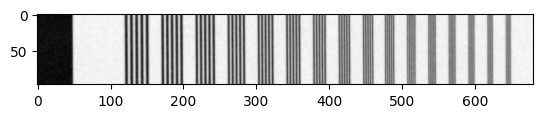

In [97]:
plt.subplot(2, 1, 1)
display(focus, True)

In [98]:
focus.shape 

(96, 680)

In [99]:
focus_crop

(174, 270, 138, 818)

In [100]:
focus_crop

(174, 270, 138, 818)

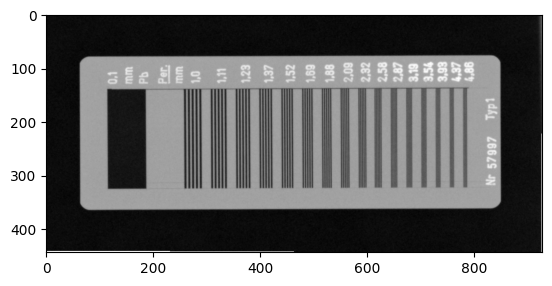

In [101]:
display(rotate_img, True)

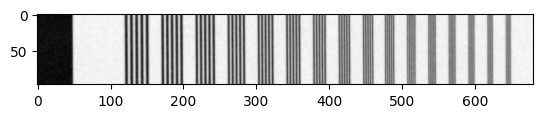

In [102]:
display(rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]], True)

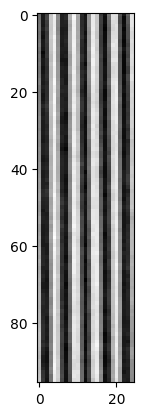

In [103]:
lp = 4
display(focus[:, positions[lp][0]: positions[lp][1]], True)

In [104]:
linepairs = []
for idx in range(len(positions)) :
    if idx < 9 :
        trim = int(0.0028*len(oneline))
    else :
        trim = int(0.004*len(oneline))
    s1, s2 = positions[idx][0]+trim, positions[idx][1]-trim
    if s2 > s1 : 
        linepairs.append((s1, s2))
    else :
        linepairs.append((s1+1, s1+2))

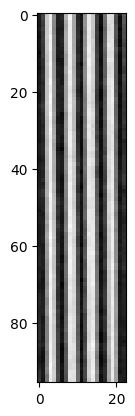

In [105]:
linepair_idx = 4
display(focus[:, linepairs[linepair_idx][0]: linepairs[linepair_idx][1]], True)

In [106]:
focus.shape, linepairs, oneline_ori.shape, arr.shape

((96, 680),
 [(1, 49),
  (121, 152),
  (171, 199),
  (218, 243),
  (262, 285),
  (303, 324),
  (342, 360),
  (379, 395),
  (414, 429),
  (449, 459),
  (479, 488),
  (509, 517),
  (538, 545),
  (566, 572),
  (593, 598),
  (619, 623),
  (645, 648)],
 (680,),
 (444, 928))

In [107]:
linepairs

[(1, 49),
 (121, 152),
 (171, 199),
 (218, 243),
 (262, 285),
 (303, 324),
 (342, 360),
 (379, 395),
 (414, 429),
 (449, 459),
 (479, 488),
 (509, 517),
 (538, 545),
 (566, 572),
 (593, 598),
 (619, 623),
 (645, 648)]

In [108]:
oneline_ori[s1: s2]

array([1015, 1007, 1011], dtype=uint32)

In [109]:
# adjust_percent = 0.035
# reduce_rate = 0.95
# for idx, (s1, s2) in enumerate(linepairs[1:], start=1) :
#     # for lp > 8
#     if idx == 8 :
#         adjust_percent = 0.02
#     vals = oneline_ori[s1: s2]
#     sorted_vals = np.sort(vals)
#     min_val = sorted_vals[0]
#     max_val = sorted_vals[-1]
#     median_val = sorted_vals[int((s2-s1)/2)]
#     adaptive_vals = []
#     for val in vals :
#         if val > median_val :
#             adapt_val = int(val)-int(adjust_percent*max_val)
#         else :
#             adapt_val = int(val)+int(adjust_percent*min_val)
#         adaptive_vals.append(adapt_val)
#     oneline_ori[s1: s2] = adaptive_vals

In [110]:
max_val0 = int(np.max(oneline_ori[linepairs[0][1]: linepairs[1][0]]))
min_val0 = int(np.min(oneline_ori[linepairs[0][0]: linepairs[0][1]]))
max_contrast = max_val0 - min_val0
min_val0, max_val0, max_contrast

(683, 1333, 650)

In [111]:
# s1, s2 = linepairs[0][0], linepairs[0][1]
# mean_val_col = oneline_ori[s1: s2]
# sorted_val = np.sort(mean_val_col) # to seperate max and min vals
# mid_pos = max(min((s2-s1)//2, int(0.21*(s2-s1))), 1) # how to select actual value, 1 if 0
# # mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
# # mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
# min_val0 = round(np.mean(sorted_val[: mid_pos]))
# max_val0 = round(np.mean(sorted_val[-mid_pos: ]))

# max_contrast = max_val0 - min_val0
# min_val0, max_val0, max_contrast

In [112]:
linepairs

[(1, 49),
 (121, 152),
 (171, 199),
 (218, 243),
 (262, 285),
 (303, 324),
 (342, 360),
 (379, 395),
 (414, 429),
 (449, 459),
 (479, 488),
 (509, 517),
 (538, 545),
 (566, 572),
 (593, 598),
 (619, 623),
 (645, 648)]

In [113]:
res = {"Linepair": [0], "Max": [max_val0], "Min": [min_val0], "Contrast": [max_contrast], "Modulation": [100]}
for idx, (s1, s2) in enumerate(linepairs[1:], start=1) :
    # in case of MTF bar (hardware error)
    if idx == 13 :
        continue     
    # if idx == 15 : # change bar 13
    #     new_max = (res["Max"][12] + res["Max"][14])//2
    #     new_min = (res["Min"][12] + res["Min"][14])//2
    #     new_contrast = new_max - new_min
    #     new_modulation = round(new_contrast*100/max_contrast, 3)
    #     res["Max"][13] = new_max
    #     res["Min"][13] = new_min
    #     res["Contrast"][13] = new_contrast
    #     res["Modulation"][13] = new_modulation

    # linepair = focus[:, s1: s2]
    # mean_val_col = np.mean(linepair, axis=0)
    mean_val_col = oneline_ori[s1: s2]
    sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    if idx < 7 :
        w = 0.21
    else :
        w = 0.35
    mid_pos = max(min((s2-s1)//2, int(w*(s2-s1))), 1) # how to select actual value, 1 if 0
    # mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    # mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    min_vals = round(np.mean(sorted_val[: mid_pos]))
    max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    # min_vals = np.min(mean_min_vals)
    # max_vals = np.max(mean_max_vals)
    # min_vals = np.min(mean_val_col)
    # max_vals = np.max(mean_val_col)
    contrast = max_vals-min_vals
    res["Linepair"].append(idx)
    res["Max"].append(max_vals)
    res["Min"].append(min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round(contrast*100/max_contrast, 3))
res = pd.DataFrame(res)

In [114]:
# plt.figure(figsize=(10, 6))
# plt.plot(oneline_ori, color="black", linewidth=1)
# for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
#     plt.plot([s1, s2], [max_v, max_v], color="red")
#     plt.plot([s1, s2], [min_v, min_v], color="blue")
# plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
# plt.grid(True)
# plt.title("Linepairs pixel values")
# plt.ylabel("Pixel value")
# plt.xlabel("Position");

In [115]:
e1, e2 = linepairs[12][1], linepairs[13][0]
e3, e4 = linepairs[13][1], linepairs[14][0]
sk1, sk2 = int((e1+e2)/2), int((e3+e4)/2)
x = oneline_ori.tolist()[: sk1] + oneline_ori.tolist()[sk2 :]

In [116]:
# plt.figure(figsize=(10, 6))
# start_val = linepairs[0][0] - (linepairs[0][1] - linepairs[0][0])
# plt.plot(x[start_val :], color="black", linewidth=1)
# for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
#     plt.plot([s1-start_val, s2-start_val], [max_v, max_v], color="red")
#     plt.plot([s1-start_val, s2-start_val], [min_v, min_v], color="blue")
# plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
# plt.grid(True)
# plt.title("Linepairs pixel values")
# plt.ylabel("Pixel value")
# plt.xlabel("Position");

In [117]:
focus_crop

(174, 270, 138, 818)

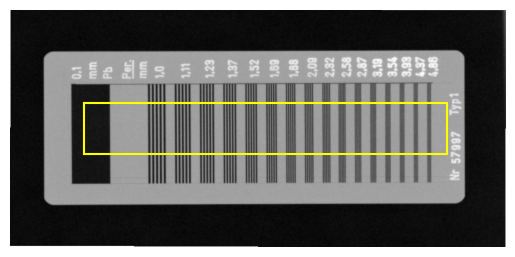

In [118]:
display(rotate_img)
# [x1, x2] [y1, y2]
plt.plot([focus_crop[2], focus_crop[2]], [focus_crop[0], focus_crop[1]], c='yellow') # left
plt.plot([focus_crop[3], focus_crop[3]], [focus_crop[0], focus_crop[1]], c='yellow') # right
plt.plot([focus_crop[2], focus_crop[3]], [focus_crop[0], focus_crop[0]], c='yellow') # top
plt.plot([focus_crop[2], focus_crop[3]], [focus_crop[1], focus_crop[1]], c='yellow') # bottom

In [119]:
start_val

643

In [120]:
linepairs

[(1, 49),
 (121, 152),
 (171, 199),
 (218, 243),
 (262, 285),
 (303, 324),
 (342, 360),
 (379, 395),
 (414, 429),
 (449, 459),
 (479, 488),
 (509, 517),
 (538, 545),
 (566, 572),
 (593, 598),
 (619, 623),
 (645, 648)]

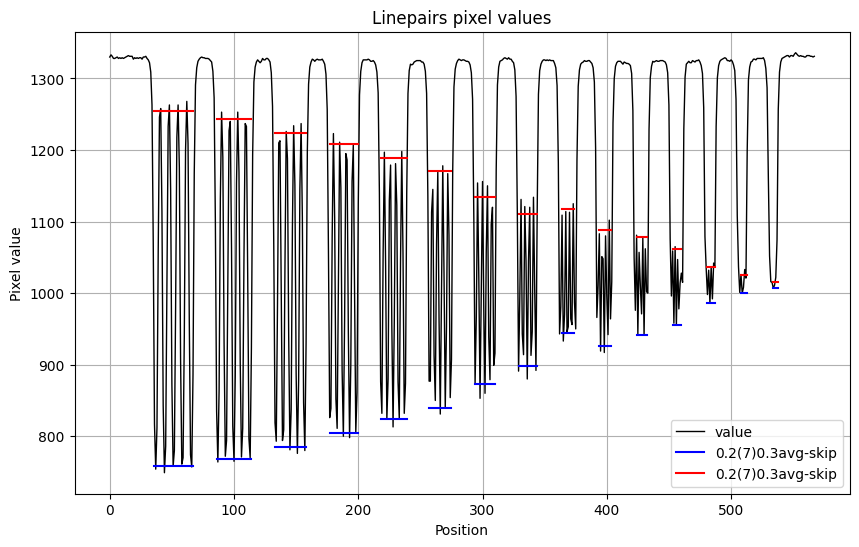

In [121]:
plt.figure(figsize=(10, 6))
start_val = int((linepairs[0][1] + linepairs[1][0]) / 2)
plt.plot(x[start_val:], color="black", linewidth=1)
for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs[1:], res.values[1:]), start=1) :
    plt.plot([s1-start_val, s2-start_val], [min_v, min_v], color="blue")
    plt.plot([s1-start_val, s2-start_val], [max_v, max_v], color="red")
plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
plt.grid(True)
plt.title("Linepairs pixel values")
plt.ylabel("Pixel value")
plt.xlabel("Position");

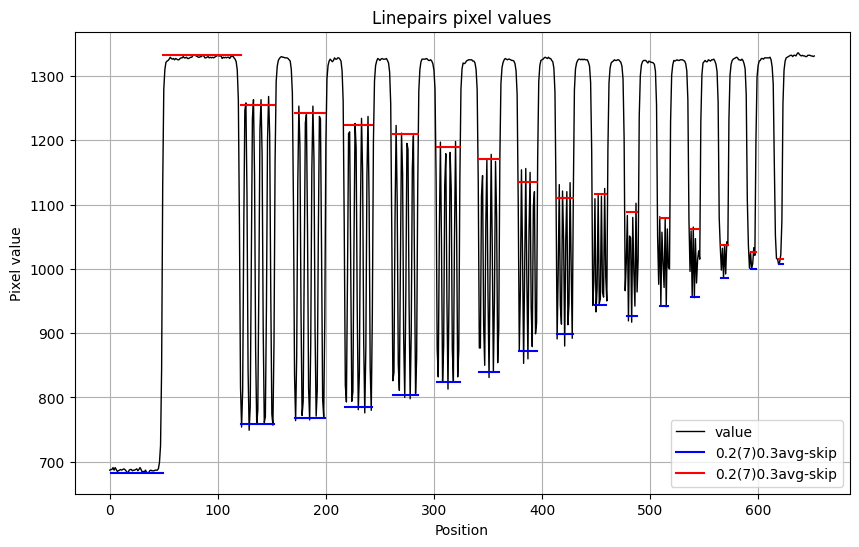

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(x, color="black", linewidth=1)
for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
    # fix position in first lp (maximum)
    plt.plot([s1, s2], [min_v, min_v], color="blue")
    if idx == 1 :
        s1 = s2
        s2 = linepairs[1][0]
    plt.plot([s1, s2], [max_v, max_v], color="red")
plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
plt.grid(True)
plt.title("Linepairs pixel values")
plt.ylabel("Pixel value")
plt.xlabel("Position");

In [123]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,1333,683,650,100.000
1,1,1255,758,497,76.462
2,2,1243,768,475,73.077
3,3,1224,785,439,67.538
4,4,1209,804,405,62.308
5,5,1189,824,365,56.154
6,6,1171,840,331,50.923
7,7,1135,873,262,40.308
8,8,1110,898,212,32.615
9,9,1117,944,173,26.615


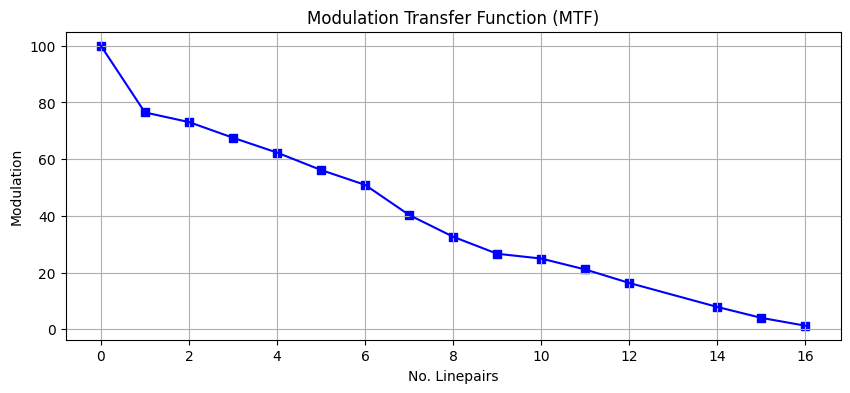

In [124]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");

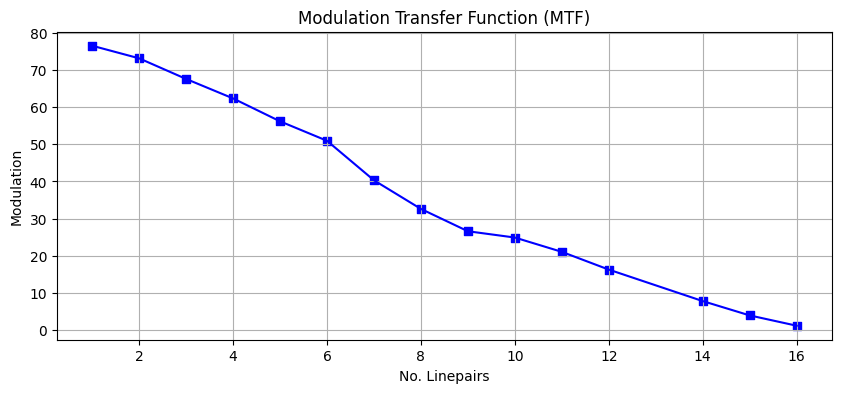

In [125]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"][1:], res["Modulation"][1:], color="blue")
plt.scatter(res["Linepair"][1:], res["Modulation"][1:], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");

In [126]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

In [127]:
x = np.array([
  1.0,
  1.11,
  1.23,
  1.37,
  1.52,
  1.69,
  1.88,
  2.09,
  2.32,
  2.58,
  2.87,
  3.19,
  3.93,
  4.37,
  4.86,
]).reshape(-1, 1)
y = res["Modulation"][1:]
poly = PolynomialFeatures(degree=3)
x_new = poly.fit_transform(x)
m = LinearRegression()
m.fit(x_new, y)

LinearRegression()

In [128]:
pred = m.predict(x_new)
pred

array([78.58935307, 72.8955622 , 67.06595731, 60.7482614 , 54.53060029,
       48.13614545, 41.75760716, 35.5798527 , 29.76973478, 24.27265258,
       19.29698251, 14.96840961,  8.05257495,  4.83025717,  0.8910488 ])

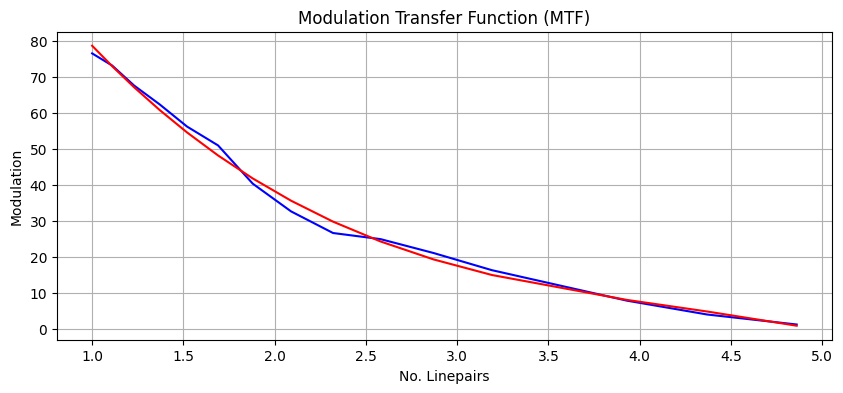

In [129]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot([
  1.0,
  1.11,
  1.23,
  1.37,
  1.52,
  1.69,
  1.88,
  2.09,
  2.32,
  2.58,
  2.87,
  3.19,
  3.93,
  4.37,
  4.86,
], res["Modulation"][1:], color="blue")
plt.plot(x, pred, color="red")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");

In [130]:
x = np.array([
  1.0,
  1.11,
  1.23,
  1.37,
  1.52,
  1.69,
  1.88,
  2.09,
  2.32,
  2.58,
  2.87,
  3.19,
  3.93,
  4.37,
  4.86,
])
y = np.array(res["Modulation"][1:]).reshape(-1, 1)
poly = PolynomialFeatures(degree=3)
y_new = poly.fit_transform(y)
t = LinearRegression()
t.fit(y_new, x)

LinearRegression()

In [131]:
yy = poly.fit_transform(np.array([40]).reshape(-1, 1))
t.predict(yy)

array([1.88905279])